In [1]:
%reset

In [2]:
from datamaker_f import VideoDataGenerator
from pipeline_f import build_full_model
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from io import BytesIO
from PIL import Image
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
# Function to convert byte arrays back to PIL images
def bytes_to_pil(byte_data):
    with BytesIO(byte_data) as buffer:
        return Image.open(buffer)

In [3]:
# Load the dataset from the pickle file
with open("D:/Projects/Face-Swap-Detection-Model/video_data_2600_001.pkl", "rb") as f:
    pickled_data = pickle.load(f)

In [4]:
# Print the structure of one sample entry
sample_video = list(pickled_data.keys())[0]  # Take the first video folder as an example
print(f"Sample video '{sample_video}' structure:")
print("Frames count:", len(pickled_data[sample_video]['frames']))
print("Frames labels count:", len(pickled_data[sample_video]['frames_label']))
print("Micro-expression count:", len(pickled_data[sample_video]['Micro_Expression']))
print("Micro-expression labels count:", len(pickled_data[sample_video]['Micro_Expression_label']))

Sample video '000' structure:
Frames count: 395
Frames labels count: 395
Micro-expression count: 1185
Micro-expression labels count: 1185


In [5]:
# Verify consistency across all video folders
for video_folder, data in pickled_data.items():
    assert len(data['frames']) == len(data['frames_label']), f"Mismatch in frames and labels for {video_folder}"
    assert len(data['Micro_Expression']) == len(data['Micro_Expression_label']), f"Mismatch in micro expressions and labels for {video_folder}"
print("All data and label pairs are consistent in length.")

All data and label pairs are consistent in length.


In [ ]:
# Convert your video_data dictionary to a list of items for easier splitting
data_items = list(pickled_data.items())
video_names, labels = zip(*[(video_name, video_info['frames_label'][0]) for video_name, video_info in pickled_data.items()])

In [ ]:
# Split the data
train_names, test_names, train_labels, test_labels = train_test_split(video_names, labels, test_size=0.3, random_state=42)
train_names, val_names, train_labels, val_labels = train_test_split(train_names, train_labels, test_size=0.2, random_state=44)

In [ ]:
# Prepare dictionaries for each split
train_data = {name: pickled_data[name] for name in train_names}
val_data = {name: pickled_data[name] for name in val_names}
test_data = {name: pickled_data[name] for name in test_names}

In [ ]:
#length of train and test data
print(len(train_data))
print(len(val_data))
print(len(test_data))

1491
373
799


In [ ]:
# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,1), dtype=tf.float32)
)

train_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(train_data),
    output_signature=output_signature
)


val_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(val_data),
    output_signature=output_signature
)

test_generator = tf.data.Dataset.from_generator(
    lambda: VideoDataGenerator(test_data),
    output_signature=output_signature
)

X_frames shape: (32, 224, 224, 3)
X_micro_exp shape: (32, 64, 64, 3)
y shape: (32, 1)


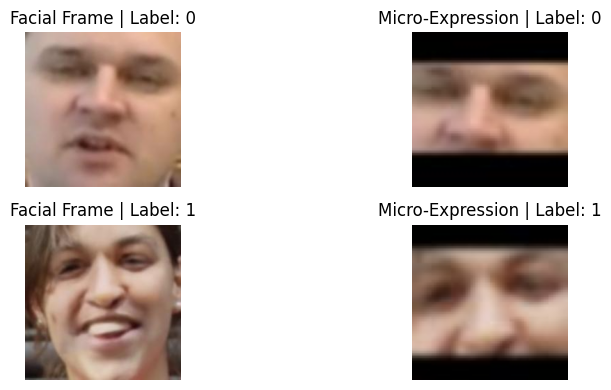

In [13]:
import matplotlib.pyplot as plt

# Initialize flags to track if we've found samples of each class
found_label_0 = False
found_label_1 = False

# Take a batch and unpack it
for batch in train_generator.take(1):
    (X_frames, X_micro_exp), y = batch

    # Print the shapes to verify
    print(f"X_frames shape: {X_frames.shape}")
    print(f"X_micro_exp shape: {X_micro_exp.shape}")
    print(f"y shape: {y.shape}")

    # Loop through the batch to find examples of both labels
    for sample_index in range(len(y)):
        sample_label = int(y[sample_index].numpy()[0])  # Assuming binary classification

        # Check if we already have examples for each label
        if sample_label == 0 and not found_label_0:
            found_label_0 = True
            sample_frame_0 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_0 = X_micro_exp[sample_index].numpy().astype("uint8")

        elif sample_label == 1 and not found_label_1:
            found_label_1 = True
            sample_frame_1 = X_frames[sample_index].numpy().astype("uint8")
            sample_micro_exp_1 = X_micro_exp[sample_index].numpy().astype("uint8")

        # Break loop once we have both examples
        if found_label_0 and found_label_1:
            break

# Display images for both labels
plt.figure(figsize=(10, 4))

# Display facial and micro-expression frames for label 0
plt.subplot(2, 2, 1)
plt.imshow(sample_frame_0)
plt.title("Facial Frame | Label: 0")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(sample_micro_exp_0)
plt.title("Micro-Expression | Label: 0")
plt.axis("off")

# Display facial and micro-expression frames for label 1
plt.subplot(2, 2, 3)
plt.imshow(sample_frame_1)
plt.title("Facial Frame | Label: 1")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sample_micro_exp_1)
plt.title("Micro-Expression | Label: 1")
plt.axis("off")

plt.tight_layout()
plt.show()


In [18]:
model_test_1 = build_full_model()

In [19]:
optimizer = Adam(learning_rate=1e-4)

In [20]:
# compile the model
model_test_1.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=5e-6
)

In [15]:
# Train the model with callbacks
history = model_test_1.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping],
    batch_size=32
)

Epoch 1/60


47/47 [==============================] - 523s 5s/step - loss: 1.0849 - accuracy: 0.5205 - val_loss: 0.7512 - val_accuracy: 0.6005 - lr: 1.0000e-04
Epoch 2/60
47/47 [==============================] - 187s 4s/step - loss: 0.7934 - accuracy: 0.5949 - val_loss: 0.6180 - val_accuracy: 0.6622 - lr: 1.0000e-04
Epoch 3/60
47/47 [==============================] - 184s 4s/step - loss: 0.6183 - accuracy: 0.6995 - val_loss: 0.9529 - val_accuracy: 0.6327 - lr: 1.0000e-04
Epoch 4/60
47/47 [==============================] - 185s 4s/step - loss: 0.4813 - accuracy: 0.8089 - val_loss: 0.3225 - val_accuracy: 0.9142 - lr: 1.0000e-04
Epoch 5/60
47/47 [==============================] - 184s 4s/step - loss: 0.3704 - accuracy: 0.8692 - val_loss: 0.6491 - val_accuracy: 0.7560 - lr: 1.0000e-04
Epoch 6/60
47/47 [==============================] - 183s 4s/step - loss: 0.3048 - accuracy: 0.9068 - val_loss: 1.0087 - val_accuracy: 0.7346 - lr: 1.0000e-04
Epoch 7/60
47/47 [==============================] 

In [16]:
# Evaluate the model
test_loss, test_accuracy = model_test_1.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

25/25 [==============================] - 31s 1s/step - loss: 0.3341 - accuracy: 0.8986
Test Loss: 0.3341386020183563, Test Accuracy: 0.8986232876777649


In [17]:
test_prediction = model_test_1.predict(test_generator)

25/25 [==============================] - 39s 1s/step


In [18]:
# Extract true labels from the test generator
y_true = np.concatenate([y for _, y in test_generator], axis=0)

In [19]:
# Assuming test_predictions contains probabilities for the positive class
test_pred_labels = (test_prediction > 0.5).astype(int)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [21]:
# Calculate performance metrics
accuracy = accuracy_score(y_true, test_pred_labels)
precision = precision_score(y_true, test_pred_labels, average='weighted')  # Use 'macro' or 'micro' as needed
recall = recall_score(y_true, test_pred_labels, average='weighted')
f1 = f1_score(y_true, test_pred_labels, average='weighted')
confusion_mat = confusion_matrix(y_true, test_pred_labels)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", confusion_mat)

Accuracy: 0.8986
Precision: 0.9029
Recall: 0.8986
F1 Score: 0.8986
Confusion Matrix:
 [[358  60]
 [ 21 360]]


In [22]:
report = classification_report(y_true, test_pred_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       418
         1.0       0.86      0.94      0.90       381

    accuracy                           0.90       799
   macro avg       0.90      0.90      0.90       799
weighted avg       0.90      0.90      0.90       799



In [23]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

In [24]:
# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_true, test_prediction)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9554


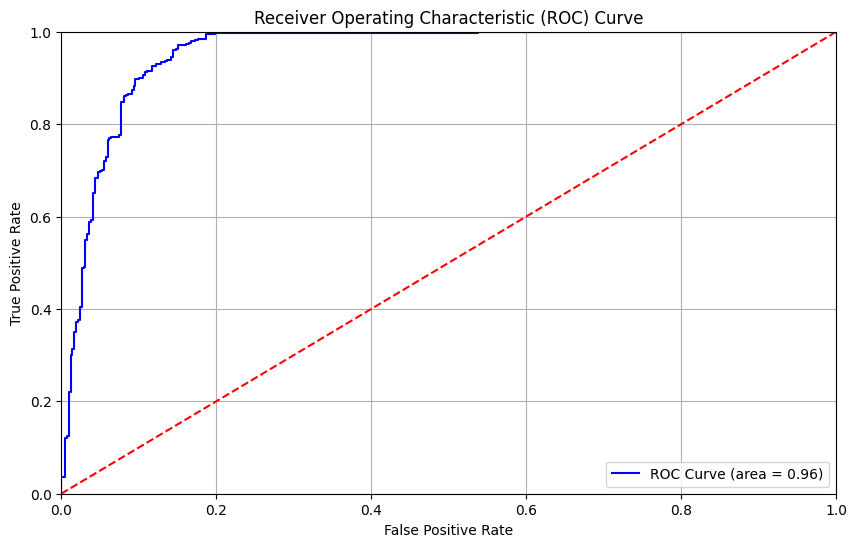

In [25]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, test_prediction)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

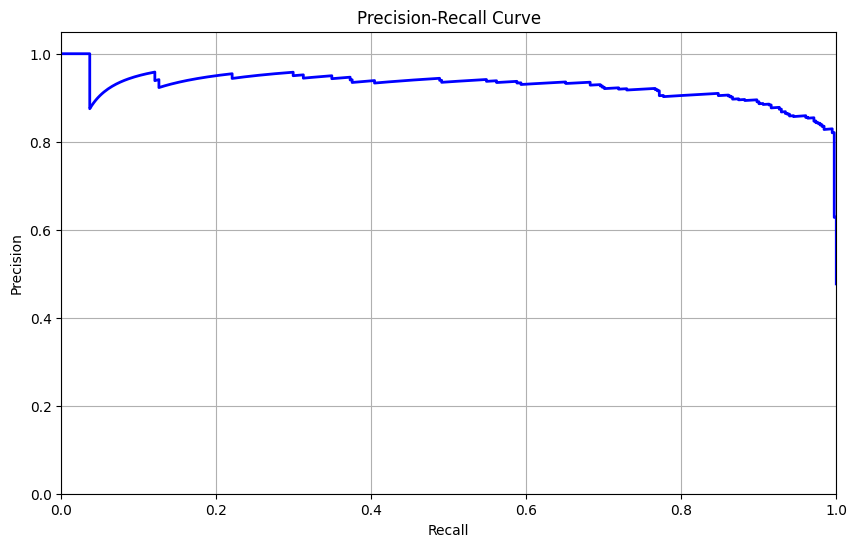

In [26]:
from sklearn.metrics import precision_recall_curve

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_true, test_prediction)

# Plotting the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

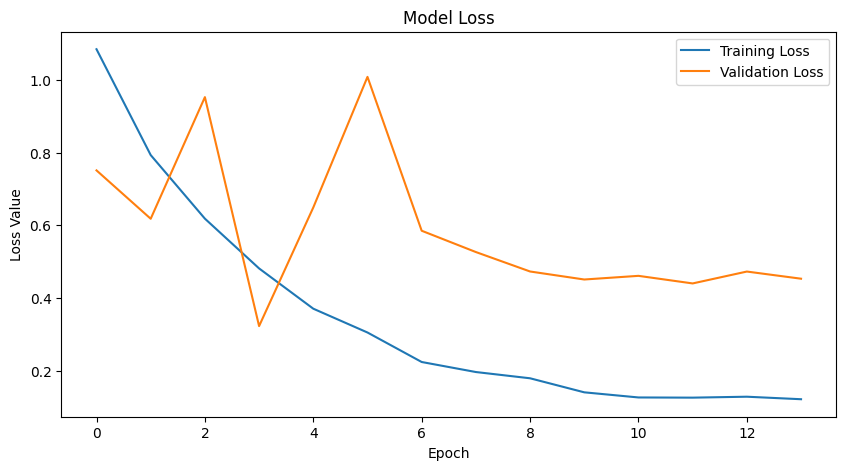

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()


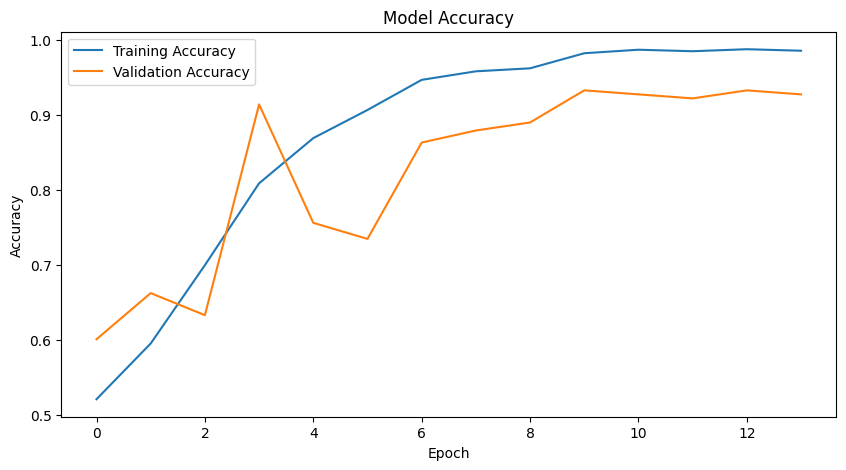

In [28]:
if 'accuracy' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


25/25 [==============================] - 34s 1s/step


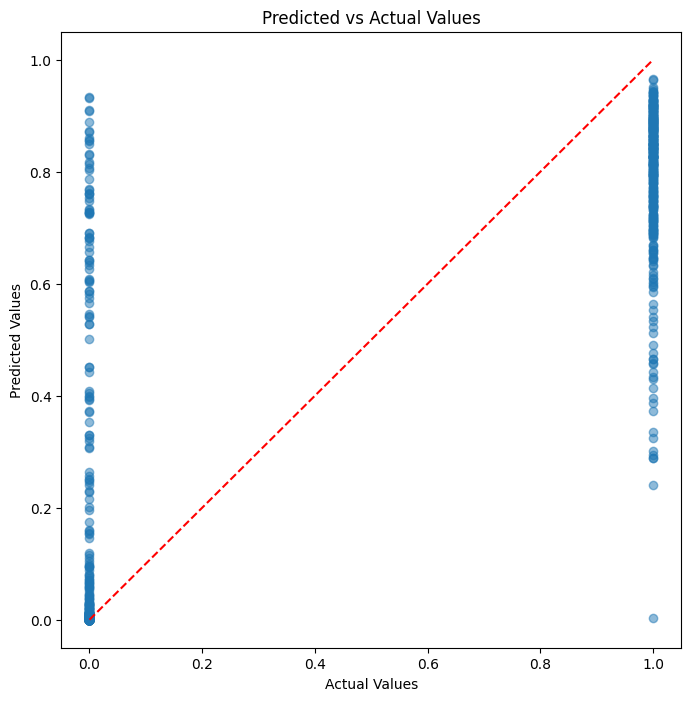

In [29]:
# Assuming the test set predictions and actual values
test_preds = model_test_1.predict(test_generator)
test_labels = np.concatenate([y for _, y in test_generator], axis=0)

plt.figure(figsize=(8, 8))
plt.scatter(test_labels, test_preds, alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()


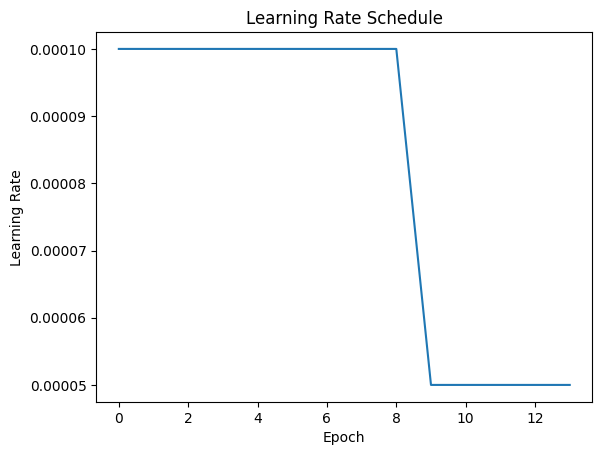

In [30]:
# Assuming `history.history` contains learning rate logs
if 'lr' in history.history:
    plt.plot(history.history['lr'])
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()


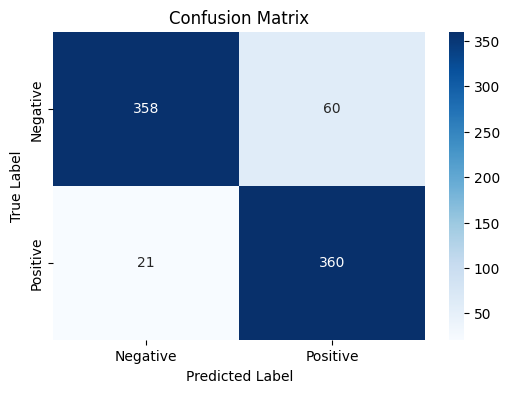

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, test_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


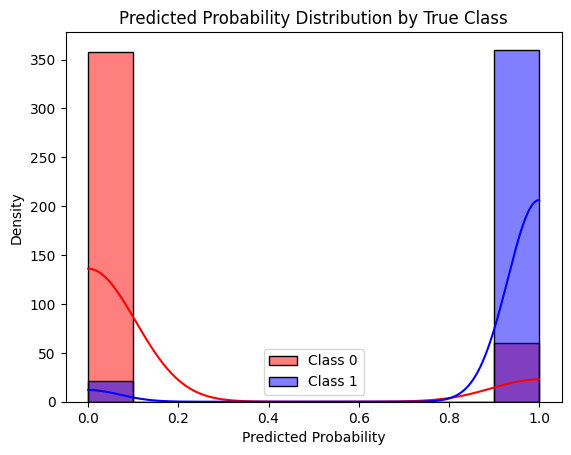

In [32]:
import seaborn as sns

# Assuming binary classification with predictions between 0 and 1
sns.histplot(test_pred_labels[y_true == 0], color="red", label="Class 0", kde=True)
sns.histplot(test_pred_labels[y_true == 1], color="blue", label="Class 1", kde=True)
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Predicted Probability Distribution by True Class")
plt.legend()
plt.show()


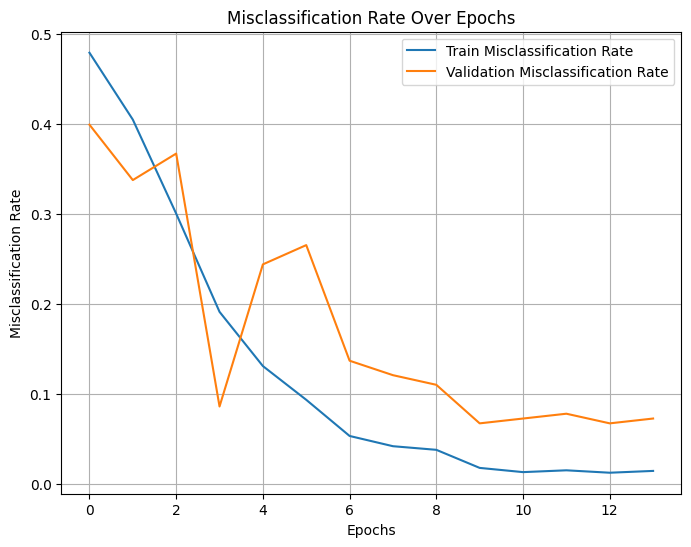

In [33]:
# Misclassification rate for train and validation data
train_misclassification = [1 - acc for acc in history.history['accuracy']]
val_misclassification = [1 - val_acc for val_acc in history.history['val_accuracy']]

# Plot misclassification rates
plt.figure(figsize=(8, 6))
plt.plot(train_misclassification, label='Train Misclassification Rate')
plt.plot(val_misclassification, label='Validation Misclassification Rate')
plt.xlabel('Epochs')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_labels, test_preds)
mse = mean_squared_error(test_labels, test_preds)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')


Mean Absolute Error (MAE): 0.17093628644943237
Mean Squared Error (MSE): 0.07383406162261963


In [1]:
from tensorflow.keras.models import load_model

l_1_model = load_model('../../saved/model_test_1_acc_90.h5')

c:\Users\USER\anaconda3\envs\Face-Swap-Detection-Model\Lib\site-packages\keras\src\layers\core\lambda_layer.py:327: UserWarning: pipeline_f is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


In [10]:
l1_loss, l1_acc = l_1_model.evaluate(test_generator)

print(f"l1 accuracy: {l1_acc}")
print(f"l1_loss: {l1_loss}")


25/25 [==============================] - 96s 1s/step - loss: 0.2942 - accuracy: 0.9074
l1 accuracy: 0.9073842167854309
l1_loss: 0.29417553544044495


## Test 2: Model Evaluation with Mean Squared Logarithmic Error (MSLE) Loss Function

In this test, we will evaluate the same model (`model_test_1`) but with a different loss function, Mean Squared Logarithmic Error (MSLE). MSLE is useful for regression problems where we want to penalize underestimation more than overestimation. It is particularly effective when dealing with data that spans several orders of magnitude. We will recompile the model with the MSLE loss function and then train and evaluate it to compare the performance with the previous test.

In [ ]:
model_test_2 = build_full_model()

In [ ]:
optimizer_2 = Adam(learning_rate=1e-4)

In [ ]:
model_test_2.compile(
    optimizer=optimizer_2,
    loss='mean_squared_logarithmic_error',
    metrics=['accuracy']
)

In [ ]:
model_test_2.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[lr_scheduler, early_stopping],
    batch_size=32
)

Epoch 1/60


